General idea:
* clean text
* get w2v features
* get lda topic modeling features
* cluster by combined features

References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [1]:
import codecs

with codecs.open(r'Forum utterances (FR).csv', encoding='latin1') as f:
    data_strings =  f.readlines()

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('Forum utterances (FR).csv', delimiter='\n', encoding='latin1', header=None)

In [4]:
data.columns=['text']

In [5]:
import spacy

In [6]:
nlp = spacy.blank('fr')

In [7]:
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [10]:
doc = nlp(data['text'][0])

In [11]:
[sent for sent in doc.sents]

[_Male, type occidental, obèse, pas de consommation d'alcool du tout, gros fumeur (invétéré !),
 .Je vais atteindre 60 ans dans deux mois.,
 Je pense reconnaître les symptômes d'un cancer pancréatique ou d'une pancréatite chronique, après un début de diabète apparu il y a quelques mois, avec lourdes douleurs lombaires dûes à une hernie discale (L5-R1?),
 vieille de deux ans, avec;;;;;;;]

In [100]:
nlp(data[0][0]).similarity(nlp(data[0][8]))

0.0

In [8]:
sentences = list(nlp('\n'.join(data[0].values)).sents)

In [9]:
len(sentences)

3270

In [93]:
sentences[10]

['a', 'propos', 'du', 'site', 'internet', 'psychoactif']

In [96]:
data = pd.DataFrame(list(map(lambda x: ' '.join(x), sentences)), columns=['text'])

In [148]:
data['text'].drop_duplicates().shape, data.shape

((3664,), (4684, 10))

## Preprocess texts

### Tokenize the text

In [11]:
import nltk, re

In [97]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [100]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(data)

### Clean the text

In [108]:
def remove_stopwords(df):
    stopwords = nltk.corpus.stopwords.words('french')
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))
remove_stopwords(data)

In [109]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

In [110]:
from gensim.corpora import Dictionary

In [111]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

2018-11-21 18:31:49,380 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-11-21 18:31:49,466 : INFO : built Dictionary(7241 unique tokens: ['!', 'consomm', 'dalcool', 'fumeur', 'gro']...) from 4684 documents (total 53256 corpus positions)


Found 7241 words.


In [113]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)

In [114]:
def lda_preprocessing(df):
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Let's plot

In [101]:
from collections import Counter

In [102]:
import numpy as np

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def word_frequency_barplot(df, nr_top_words=50):
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)
    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [115]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [116]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

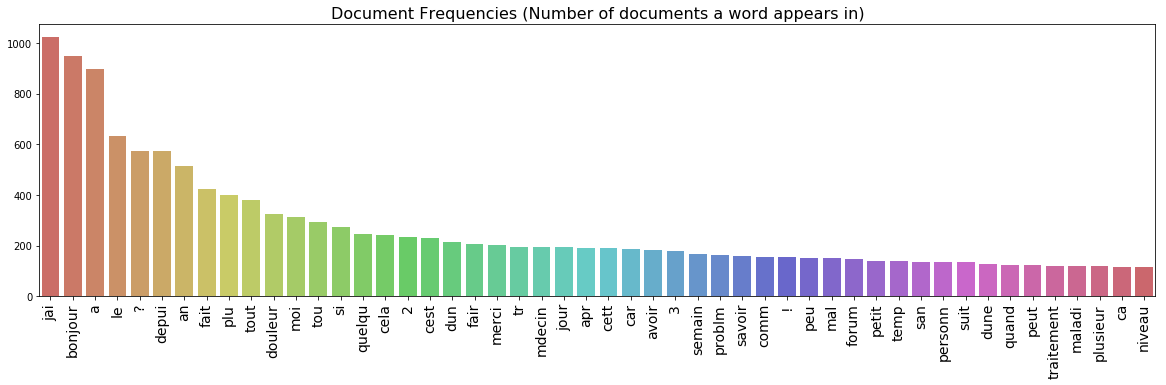

In [117]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

## W2V features

In [118]:
sentences = []
for sentence_group in data.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 4684.
Number of texts: 4684.


In [119]:
from gensim.models import Word2Vec

In [120]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

2018-11-21 18:31:58,350 : INFO : collecting all words and their counts
2018-11-21 18:31:58,351 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-11-21 18:31:58,369 : INFO : collected 8888 word types from a corpus of 84511 raw words and 4684 sentences
2018-11-21 18:31:58,369 : INFO : Loading a fresh vocabulary
2018-11-21 18:31:58,379 : INFO : effective_min_count=3 retains 3018 unique words (33% of original 8888, drops 5870)
2018-11-21 18:31:58,379 : INFO : effective_min_count=3 leaves 77256 word corpus (91% of original 84511, drops 7255)
2018-11-21 18:31:58,390 : INFO : deleting the raw counts dictionary of 8888 items
2018-11-21 18:31:58,391 : INFO : sample=0.001 downsamples 56 most-common words
2018-11-21 18:31:58,393 : INFO : downsampling leaves estimated 55166 word corpus (71.4% of prior 77256)
2018-11-21 18:31:58,405 : INFO : estimated required memory for 3018 words and 200 dimensions: 6337800 bytes
2018-11-21 18:31:58,406 : INFO : resetting layer weigh

In [121]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.tokenized_sentences))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [122]:
W2Vmodel.wv.similarity(w1='peux', w2='cancer')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.53435516

## LDA features

In [123]:
from gensim.models import LdaModel, LdaMulticore

In [124]:
from gensim.test.utils import common_corpus

In [125]:
corpus = data.bow

In [126]:
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

2018-11-21 18:32:09,468 : INFO : using asymmetric alpha [0.031139033, 0.028788464, 0.02676786, 0.025012296, 0.023472836, 0.02211189, 0.020900112, 0.019814245, 0.018835641, 0.017949153, 0.017142355, 0.01640497, 0.015728405, 0.015105434, 0.014529934, 0.013996676, 0.013501173, 0.0130395545, 0.012608458, 0.012204954, 0.011826476, 0.011470766, 0.011135828, 0.010819895, 0.010521393, 0.010238921, 0.009971219, 0.009717159, 0.009475723, 0.0092459945, 0.009027141, 0.008818409, 0.008619112, 0.008428624, 0.008246372, 0.008071837, 0.007904536, 0.0077440296, 0.0075899116, 0.0074418085, 0.0072993743, 0.0071622906, 0.0070302603, 0.00690301, 0.0067802845, 0.0066618463, 0.006547475, 0.006436964, 0.006330122, 0.0062267683, 0.0061267363, 0.0060298666, 0.005936013, 0.0058450364, 0.0057568057, 0.0056711994, 0.0055881017, 0.005507404, 0.005429004, 0.005352805, 0.005278715, 0.0052066483, 0.0051365225, 0.0050682607, 0.0050017894, 0.0049370397, 0.0048739444, 0.0048124413, 0.004752471, 0.0046939775, 0.004636906,

2018-11-21 18:32:18,493 : INFO : topic diff=inf, rho=0.439757
2018-11-21 18:32:18,879 : INFO : -8.154 per-word bound, 284.8 perplexity estimate based on a held-out corpus of 684 documents with 8030 words
2018-11-21 18:32:18,881 : INFO : PROGRESS: pass 4, dispatched chunk #0 = documents up to #4000/4684, outstanding queue size 1
2018-11-21 18:32:18,903 : INFO : PROGRESS: pass 4, dispatched chunk #1 = documents up to #4684/4684, outstanding queue size 2
2018-11-21 18:32:20,322 : INFO : topic #149 (0.002): 0.033*"a" + 0.024*"si" + 0.022*"o" + 0.022*"cri" + 0.021*"jai" + 0.015*"mavait" + 0.015*"tl" + 0.013*"fait" + 0.012*"lheur" + 0.012*"tou"
2018-11-21 18:32:20,323 : INFO : topic #146 (0.002): 0.052*"tout" + 0.048*"petit" + 0.032*"bouton" + 0.030*"semain" + 0.028*"a" + 0.022*"dessu" + 0.019*"fait" + 0.013*"mal" + 0.013*"afin" + 0.013*"tsh"
2018-11-21 18:32:20,325 : INFO : topic #2 (0.027): 0.035*"a" + 0.020*"bonjour" + 0.014*"le" + 0.012*"depui" + 0.011*"an" + 0.011*"jai" + 0.009*"tou" + 

In [127]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

## Dataset

In [129]:
X_train_lda = np.array(list(map(np.array, data.lda_features)))
X_train_w2v = np.array(list(map(np.array, data.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

In [130]:
X_train_combined.shape

(4684, 350)

## Clustering

In [61]:
from sklearn.cluster import KMeans

In [131]:
km = KMeans(5).fit(X_train_combined)

In [132]:
comp = pd.DataFrame(data['text'])

In [133]:
comp['clusters'] = km.predict(X_train_combined)

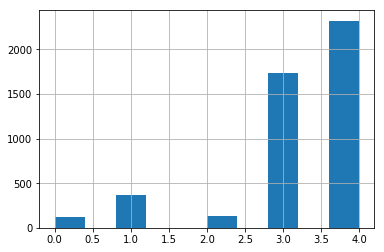

In [134]:
comp['clusters'].hist()

In [149]:
comp[comp['clusters']==1]['text'].unique()

array(['je vais atteindre 60 ans dans deux mois', 'bjr toutes et tous',
       'jai un regime alimentaire a 1200 cal et je nais pas perdu un seul gramme ! ! ! ! ! ! ! ! je suis desespere',
       'bonjour jai 56 ans', 'jai 74 ans', 'jours',
       'bonjour depuis 3j j ? ai environ des selles noir',
       'bonjour jai fait un a', 'je nai seulement 26',
       'bonjour je suis rompu le frein pendant un rapport sexuel',
       'jai 44 ans', 'bonjour',
       'bonjour tous je me permets de demander votre avis',
       'je souffre depuis plusieurs semaines de paresthsies des extrmits dabors pas moment',
       'je suis trs angoisse',
       'bonjour tous ! jai 37ans et je suis mre de deux filles',
       'bonjour a tous ! je m ? appelle andy et jai 20 ans je pratique de la musculation depuis 1 ans et un sport d ? quipe et je suis tudiant',
       'bonjour tous ! je suis actuellement en seconde anne de bac pro assp donc en premire et jai actuellement 16 ans mes 17 ans en octobre 2017',
    

## Still to try...

### LSI

In [56]:
from gensim import corpora, models, utils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
corpus = corpora.MmCorpus('/tmp/deerwester.mm') # load a corpus of nine documents, from the Tutorials
id2word = corpora.Dictionary.load('/tmp/deerwester.dict')

In [ ]:
lsi = models.LsiModel(corpus, id2word=id2word, num_topics=200, chunksize=1, distributed=True) # run distributed LSA on nine documents

In [ ]:
W2Vmodel.wv.vocab + dictionary

In [ ]:
lsi = models.LsiModel(X_train_combined, num_topics=200, chunksize=1, distributed=True)

In [ ]:
lsi.print_topics(num_topics=2, num_words=5)